# Método Backpropagation

Este método se basa en el siguiente libro:

[1] Xudong Chen, Computational Methods for Electromagnetic Inverse Scattering

particularmente, el capítulo 6. Se utilizan códigos de su página web convertidos y modificados para python.

Autores: Ramiro Irastorza

Email: rirastorza@iflysib.unlp.edu.ar


## Algoritmo

Consta de 3 pasos:

**(1)** Determinar la corriente inducida $J$, que se asume proporcional al campo disperso (backpropagated, BP):

$$ J = \gamma G_{s}^{+}(E^{s})$$

aquí $G_{s}^{+}$ denota un operador adjunto a $G_{s}$ y mapea el campo disperso en la zona de medición (dominio $S$) en la corriente inducida en el dominio de interés ($D$). De forma discreta esta operación se escribe de la siguiente manera: $\bar{\bar{G}}^{H}\cdot \bar{E}^{s}$, donde el super índice $H$ significa operador Hermítico. El parámetro $\gamma$ se elije minimizando la función de costo:

$$F\left(\gamma\right)  = \left|\left| E^{s}-G_{s}\left(\gamma G_{s}^{+}(E^{s})\right) \right|\right|^{2}_{s} $$

**(2)** Calculo el campo total en el dominio de interés $D$:

$$E^{t}= E^{i}+G_{D}\left(J \right)$$

donde $E^{i}$ es el campo incidente. Debe remarcarse que esto se hace para cada uno de los $N_{i}$ incidentes.

**(3)** Finalmente, se obtiene la función contraste $\chi\left(r\right)$ tomando todas las ondas incidentes en cuenta. Para la onda $p_{th}$ la definición de la función contraste es:

$$J_{p}\left(r\right) = \chi\left(r\right)E_{p}^{t}\left(r\right)$$

si se resuelve con mínimos cuadrados de manera analítica, se obtiene:

$$\chi\left(r\right)  = \frac{\sum_{p=1}^{N_{i}} J_{p}\left(r\right) \cdot \left[E_{p}^{t}\left(r\right)\right]^{*}}{\sum_{p=1}^{N_{i}} \left|E_{p}^{t}\left(r\right)\right|^{2}}$$

si el dispersor no tiene pérdidas la parte imaginaria nos da el resultado.

## Código

Comenzamos cargando las librerías necesarias y algunos parámetros del arreglo de antenas (posiciones y cantidad de antenas transmisoras y receptoras), impedancia del background, frecuencia de la onda incidente y el tamaño de la región de interés.

In [1]:
import numpy as np
from scipy import constants as S
from scipy import special
import matplotlib.pyplot as plt

#-------------------------
#idem forward_Mom_test0.py
pi = S.pi
eps0 = S.epsilon_0
c = S.c
mu0 = S.mu_0

freq = 400e6
landa = c/freq # the wavelength in the air
k0 = 2*pi/landa # the wave number in the air
imp = 120*pi # impedance of air
size_DOI = 2 # size of DOI
Ni = 16 # number of incidence
Ns = 32 # number of receiving antennas
theta = np.linspace(0,2*pi-2*pi/Ni, num=Ni, endpoint=True) # angle of incidence
phi = 2*pi*np.linspace(0,(Ns-1)/Ns,num=Ns, endpoint=True) # 1 x Ns | angle of receiving antennas
R_obs = 3 # radius of the circle formed by receiving antennas
X = R_obs*np.cos(phi) # 1 x Ns x coordinates of receiving antennas
Y = R_obs*np.sin(phi) # 1 x Ns y coordinates of receiving antennas

Luego, se define una función que computa la numéricamente utilizando fft la integral de la función de Green en el dominio requerido.

In [ ]:
def Gd(J,Z,M):
    #Entradas: 
    #J: densidad de corriente
    #Z: función que hay que integrar dependientes de funciones de Hankel, 
    #   considerando constante en cada celda y cada una se considera una 
    #   circunferencia.
    #M: cantidad en que se parte el DOI.
    #Salidas:
    # Función Gd para usar en la Ec. 6.28 del libro de Chen.
    
    Ni = J.shape[1]
    J = J.reshape(M,M,Ni)
    Z = Z[:,:,np.newaxis]#cuidado! Para que funcione de manera equivalente tile y repmat
    Z = np.tile(Z,(1,1,Ni))
    opa = np.fft.ifft2(np.fft.fft2(Z,axes = (0,1))*np.fft.fft2(J,(2*M-1,2*M-1),(0,1)),axes = (0,1))
    opa = opa[0:M,0:M,:]
    opa = opa.reshape((M**2,Ni))
    
    return opa


Ahora comenzamos con el algoritmo.

0.017630924485867384
[-5.60210574e-05-0.00435789j -7.77816699e-05-0.00436348j
 -1.02679139e-04-0.00434518j -1.24212608e-04-0.00432303j
 -1.37197923e-04-0.00431532j -1.38576464e-04-0.00433583j
 -1.27740096e-04-0.00439203j -1.06357288e-04-0.0044845j
 -7.77878009e-05-0.00460749j -4.62476745e-05-0.00475045j]
(64, 64) (64, 64)
(64, 64) (64, 64)
(64, 64) (64, 64)


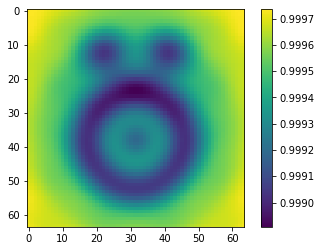

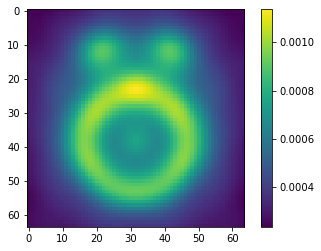

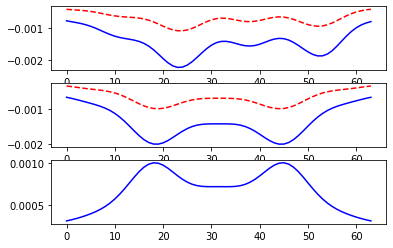

In [1]:
#Parameters (keep unchanged in the inverse problem)
#Position of the cells
M = 64 # the square DOI has a dimension of MxM % This value of M is set to be smaller than the value of M used in forward problem to avoid "inverse crime". 
d = size_DOI/M #the nearest distance of two cell centers
tx = d*np.linspace(-(M-1)/2,(M-1)/2,num=M,endpoint = True) #((-(M-1)/2):1:((M-1)/2))*d # 1 x M
ty = d*np.linspace((M-1)/2,-(M-1)/2,num=M,endpoint = True) #((-(M-1)/2):1:((M-1)/2))*d # 1 x M
x, y = np.meshgrid(tx, ty)# M x M
celldia = 2*np.sqrt(d**2/pi) # diameter of cells
cellrad = celldia/2 #radius of cells
# used to do circular convolution with the eletric diple to generate the
# scattered E field within DOI (used for calculation of Gd)
# note that one element in ZZ matrix corresponds to R = 0
X_dif,Y_dif = np.meshgrid(d*np.linspace(1-M,M-1,num=2*M-1,endpoint = True),d*np.linspace(1-M,M-1,num=2*M-1,endpoint = True))
R = np.sqrt(X_dif**2+Y_dif**2) # (2M-1) x (2M-1)
ZZ = -imp*pi*cellrad/2*special.jv(1,k0*cellrad)*special.hankel1(0,k0*R) #(2M-1) x (2M-1)
ZZ[M-1,M-1] = -imp*pi*cellrad/2*special.hankel1(1,k0*cellrad)-1j/(2*pi/landa/(imp)) # 1 x 1
Z = np.zeros((2*M-1,2*M-1),dtype = complex)
Z[:M,:M] = ZZ[(M-1):(2*M-1),(M-1):(2*M-1)]
Z[M:(2*M-1),M:(2*M-1)] = ZZ[:(M-1),:(M-1)]
Z[:M,M:(2*M-1)] = ZZ[M-1:(2*M-1),:(M-1)]
Z[M:(2*M-1),:M] = ZZ[:(M-1),(M-1):(2*M-1)]


# Calculation of Gs 
X_obs = np.tile(X.T,(M*M,1)).T# Ns x M^2
Y_obs = np.tile(Y.T,(M*M,1)).T# Ns x M^2

R = np.sqrt((X_obs-np.tile(x.reshape((M*M,1),order = 'F').T,(Ns,1)))**2+(Y_obs-np.tile(y.reshape((M*M,1),order = 'F').T,(Ns,1)))**2) # Ns x M^2

Gs = -imp*np.pi*cellrad/2*special.jv(1,k0*cellrad)*special.hankel1(0,k0*R)#Ns x M^2

#Incident wave (ONDA PLANA)
E_inc = np.exp(np.matmul((1j*k0*x.T.flatten()).reshape((M**2,1)),(np.cos(theta.T.flatten())).T.reshape((1,Ni)))+np.matmul((1j*k0*y.T.flatten()).reshape((M**2,1)),(np.sin(theta.T.flatten())).T.reshape((1,Ni))))# M^2 x Ni

##-----------------------------------------------------

#M = 40
npzfile = np.load('test_Inv_M_'+str(40)+'.npz')
E_s = npzfile['Es']

#print(Gs[:,0])
#gamma = sum(E_s.*conj(Gs*Gs'*E_s),1)./sum(abs(Gs*Gs'*E_s).^2,1); % 1 x Ni
gamma = np.sum(E_s*np.conj(np.matmul(np.matmul(Gs,np.conj(Gs).T),E_s)),axis=0)/np.sum(abs(np.matmul(np.matmul(Gs,np.conj(Gs).T),E_s))**2,axis=0) # 1 x Ni



J = np.tile(gamma,(M**2,1))*np.matmul(np.conj(Gs).T,E_s)#M^2 x Ni


Et = E_inc+Gd(J,Z,M)# M^2 x 1



num = np.sum(J*np.conj(Et),axis=1)
print(num[1:11])
den = np.sum(np.conj(Et)*Et,axis=1)

chai = (num/den).reshape((M,M)).T# M x M

plt.figure(1)
#extent2=[-0.25/2,0.25/2,-0.25/2,0.25/2]
plt.imshow(chai.imag+1,)#cmap = 'pink')#origin='lower')#,extent = extent2)#cmap = 'binary')
plt.colorbar()


#Comparando con octave
import scipy.io
#save -v7 E_s_for_test.mat E_s
chai_octave = scipy.io.loadmat('chai_for_test.mat')

chai_oct = chai_octave['chai']

plt.figure(2)
#extent2=[-0.25/2,0.25/2,-0.25/2,0.25/2]
plt.imshow(chai.imag-chai_oct.imag,)#cmap = 'pink')#origin='lower')#,extent = extent2)#cmap = 'binary')
plt.colorbar()


fig3 = plt.figure(3)
f3 = fig3.add_subplot(311)
print(chai_oct.shape,chai.shape)
f3.plot(chai_oct.imag[:,int(len(chai_oct)/2)],'b')
f3.plot(chai.imag[:,int(len(chai)/2)],'--r')
#f3.set_xlabel('Number of Rx')
#f3.set_ylabel(r'abs($E_{z}$)')
f3 = fig3.add_subplot(312)
print(chai_oct.shape,chai.shape)
f3.plot(chai_oct.imag[int(len(chai_oct)/2),:],'b')
f3.plot(chai.imag[int(len(chai)/2),:],'--r')

f3 = fig3.add_subplot(313)
print(chai_oct.shape,chai.shape)
f3.plot(chai.imag[int(len(chai)/2),:]-chai_oct.imag[int(len(chai_oct)/2),:],'b')

plt.show()

Comenzaremos a cargar los datos para cada ubicación del transmisor en sus S = 8 ubicaciones. Para eso, haremos una iteración. En _funciones_born.py_ hay algunas funciones que permiten cargar los archivos .h5, que es la extensión en la cual se guardaron los datos simulados con FDTD (software meep). Con este software "medimos" (simulamos) el campo incidente y campo total en las antenas receptoras. 